In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


# # idea:
# number of switch per trial, correlate with average F0 change

In [2]:
import database
reload(database)
db = database.thomas_18_db

In [3]:
figdir='/mnt/home/szheng/ceph/place_variability/fig/paper/suppfigure_imaging_stability'
figdir= misc.get_or_create_subdir(figdir)

/mnt/home/szheng/ceph/place_variability/fig/paper/suppfigure_imaging_stability


In [4]:
sys.path.append('/mnt/home/szheng/projects/place_variability/code/thomas_18_data')

In [5]:
import fr_map_thomas_all_sess as fmtas
reload(fmtas)
import get_thomas_cell_metrics as gtcm
reload(gtcm)
import unimodal_nmf as unmf

In [6]:
import matplotlib
matplotlib.rcParams['svg.fonttype']='none'

In [7]:
# load firing related data
import detect_field_within_minus_outside_one_exp as dfwmooe
save_data_dir = '/mnt/home/szheng/ceph/place_variability/data/thomas18'
save_data_fn = f'{dfwmooe.SAVE_FN[:-2]}_combined.p'
res=pickle.load(open(os.path.join(save_data_dir,save_data_fn),'rb'))


field_bounds_all=    res['field_bounds_all']
threshold_all=    res['threshold_all']
in_field_mask_all=    res['in_field_mask_all']
out_field_mask_all=    res['out_field_mask_all']
all_day_activation_d_all=    res['all_day_activation_d_all']


/mnt/home/szheng/projects/place_variability/code/thomas_18_data/detect_field_within_minus_outside_one_exp.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  db_grouped = db.groupby(['region','exp_ind']).mean().index # group on the level of region and exp


In [8]:
%%time
reload(fmtas)
fr_map_all = fmtas.main(force_reload=False,load_only=True,dosave=False,bin_size=0.022,gauss_width=0.2,save_fn_one='fr_map_mask_True_smallbin_smallgauss.p',save_fn_all='fr_map_mask_True_smallbin_smallgauss.p')
# fr_map_all = fmtas.main(force_reload=False,load_only=False,dosave=False)
fr_map_trial_df_all = fr_map_all['fr_map_trial_df_all']

occu_map = fr_map_all['occu_map_all']

frmap = fr_map_all['fr_map_all']
fr_map_trial_all = fr_map_all['fr_map_trial_all']

# reshape fr_map_trial_df_all to make it easier to work with
fr_map_trial_df_all_day =fr_map_trial_df_all.unstack(level=2).swaplevel(0,1,axis=1).sort_index(axis=1) # day in column

fr_map_trial_df_all_per_uid=fr_map_trial_df_all.unstack(level=(2,3)).swaplevel(0,1,axis=1).swaplevel(1,2,axis=1).sort_index(axis=1).dropna(axis=1,how='all')

frmap_all_day = frmap.unstack(level=2).swaplevel(0,1,axis=1).sort_index(level=0,axis=1)

/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/fr_map_mask_True_smallbin_smallgauss.p exists; loading---
CPU times: user 27.8 s, sys: 12.5 s, total: 40.3 s
Wall time: 1min


In [9]:
import h5py
fn_full = '/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1.h5'
f = h5py.File(fn_full, 'r')

In [10]:
# get switch
import place_field_detection_thomas as pfdt
import prep_thomas_data as ptd
reload(pfdt)
reload(ptd)

<module 'prep_thomas_data' from '/mnt/home/szheng/projects/place_variability/code/thomas_18_data/prep_thomas_data.py'>

In [20]:
exp_ind = 0
day_ind = 1
sw = 'on'
famnov=0
region='CA1'
sw_mag_thresh = 0.3

F0_alltrials_allcells = ptd.get_F0_one_exp_one_cat(f,exp_ind=exp_ind,day_ind=day_ind,famnov=famnov,region='CA1')
F0_alltrials_allcells = pd.DataFrame(F0_alltrials_allcells)
F0_alltrials_allcells_z = scipy.stats.zscore(F0_alltrials_allcells,axis=1)

get_field_day=day_ind
threshold_sub = threshold_all.loc[(region,exp_ind,famnov,slice(None),get_field_day)]
all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))

### switch detection
sw_on_trial_l=pfdt.get_switch_trial(
    all_day_activation_sub,
    threshold_sub,
    sw_mag_thresh=sw_mag_thresh,
    trial_range = 5,
    field_present_frac = 0.6,
    field_not_present_frac=0.8,
    sw=sw
    )
sw_trial_l = sw_on_trial_l

# get switch count per trial
tr_l,sw_ct_l = np.unique(list(sw_trial_l.values()),return_counts=True)

# get F0 change
F0_df = F0_alltrials_allcells_z
F0_change_abs_mean=F0_df.diff(axis=1).abs().mean(axis=0)

F0_change_abs_mean_sub = pd.DataFrame({'F0_change':F0_change_abs_mean.loc[tr_l].values,'switch_ct':sw_ct_l})

/tmp/ipykernel_232762/3004855195.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))


In [11]:
def analyze_F0_change_per_switch_trial(
    f,
    exp_ind = 0,
    day_ind = 1,
    sw = 'on',
    famnov=0,
    region='CA1',
    sw_mag_thresh = 0.3,
    trial_range=5,
):
    

    F0_alltrials_allcells = ptd.get_F0_one_exp_one_cat(f,exp_ind=exp_ind,day_ind=day_ind,famnov=famnov,region='CA1')
    F0_alltrials_allcells = pd.DataFrame(F0_alltrials_allcells)
    F0_alltrials_allcells_z = scipy.stats.zscore(F0_alltrials_allcells,axis=1)

    get_field_day=day_ind
    threshold_sub = threshold_all.loc[(region,exp_ind,famnov,slice(None),get_field_day)]
    all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))

    ### switch detection
    sw_on_trial_l=pfdt.get_switch_trial(
        all_day_activation_sub,
        threshold_sub,
        sw_mag_thresh=sw_mag_thresh,
        trial_range = trial_range,
        field_present_frac = 0.6,
        field_not_present_frac=0.8,
        sw=sw
        )
    sw_trial_l = sw_on_trial_l

    # get switch count per trial
    tr_l,sw_ct_l = np.unique(list(sw_trial_l.values()),return_counts=True)

    # get F0 change
    F0_df = F0_alltrials_allcells_z
    F0_change_abs_mean=F0_df.diff(axis=1).abs().mean(axis=0)
    F0_change_abs_mean_sub = F0_change_abs_mean.loc[trial_range:tr_l.max()].to_frame().rename({0:'F0_change'},axis=1)
    sw_ct_l = pd.DataFrame(sw_ct_l[:,None],index=tr_l,columns=['switch_ct'])
    F0_change_abs_mean_sub=F0_change_abs_mean_sub.join(sw_ct_l).fillna(0)
    F0_change_abs_mean_sub['switch_ct_norm'] = F0_change_abs_mean_sub['switch_ct'] / all_day_activation_sub.shape[0]
    return F0_change_abs_mean_sub

In [94]:
exp_ind = 7
day_ind = 1
sw ='on'
F0_change_abs_mean_sub = analyze_F0_change_per_switch_trial(f,exp_ind=exp_ind)

/tmp/ipykernel_232762/3687954730.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))


# loop

In [13]:
region ='CA1'
exp_ind_l = all_day_activation_d_all.loc[region].index.get_level_values(0).unique()

In [14]:
%%time
day_dict = {'on':1,'off':0}
F0_change_abs_mean_sub_allexp_allsw ={}
for sw in ['on','off']:
    day_ind = day_dict[sw]
    F0_change_abs_mean_sub_allexp={}
    for exp_ind in exp_ind_l:
        try:
            F0_change_abs_mean_sub = analyze_F0_change_per_switch_trial(f,exp_ind=exp_ind,day_ind=day_ind)
            F0_change_abs_mean_sub_allexp[exp_ind] = F0_change_abs_mean_sub
        except Exception as e:
            pass
    F0_change_abs_mean_sub_allexp = pd.concat(F0_change_abs_mean_sub_allexp,axis=0)
    F0_change_abs_mean_sub_allexp_allsw[sw] = F0_change_abs_mean_sub_allexp

    


/tmp/ipykernel_947770/3687954730.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))
/tmp/ipykernel_947770/3687954730.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))
/tmp/ipykernel_947770/3687954730.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))
/tmp/ipykernel_947770/3687954730.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_

CPU times: user 54.3 s, sys: 1.12 s, total: 55.4 s
Wall time: 2min 27s


/tmp/ipykernel_947770/3687954730.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))


In [45]:
F0_change_abs_mean_sub_allexp_allsw['on'].shape

(73, 3)

In [50]:
F0_change_abs_mean_sub_allexp_allsw['on'].index.get_level_values(0).unique().shape[0]

10

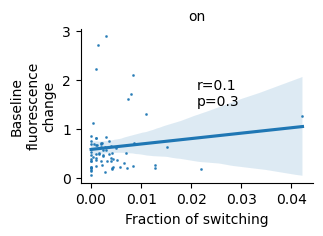

In [52]:
sw='on'
r,p=scipy.stats.pearsonr(F0_change_abs_mean_sub_allexp_allsw[sw]['F0_change'],F0_change_abs_mean_sub_allexp_allsw[sw]['switch_ct_norm'])
fig,ax=plt.subplots(figsize=(3,2))
sns.regplot(data=F0_change_abs_mean_sub_allexp_allsw[sw],x='switch_ct_norm',y='F0_change',scatter_kws={'s':1})
text = f'r={r:.1f}\np={p:.1f}'
ax.text(0.5,0.5,text,transform = ax.transAxes)
ax.set_xlabel('Fraction of switching')
ax.set_ylabel('Baseline\nfluorescence\nchange')
ax.set_title(f'{sw}')
sns.despine()

figfn = f'f0_change_vs_frac_sw_{sw}'
ph.save_given_name(fig,figfn,figdir=figdir)

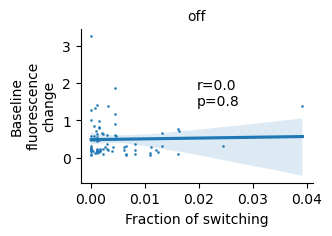

In [53]:
sw='off'
r,p=scipy.stats.pearsonr(F0_change_abs_mean_sub_allexp_allsw[sw]['F0_change'],F0_change_abs_mean_sub_allexp_allsw[sw]['switch_ct_norm'])
fig,ax=plt.subplots(figsize=(3,2))
sns.regplot(data=F0_change_abs_mean_sub_allexp_allsw[sw],x='switch_ct_norm',y='F0_change',scatter_kws={'s':1})
text = f'r={r:.1f}\np={p:.1f}'
ax.text(0.5,0.5,text,transform = ax.transAxes)
ax.set_xlabel('Fraction of switching')
ax.set_ylabel('Baseline\nfluorescence\nchange')
ax.set_title(f'{sw}')
sns.despine()

figfn = f'f0_change_vs_frac_sw_{sw}'
ph.save_given_name(fig,figfn,figdir=figdir)

In [51]:
F0_change_abs_mean_sub_allexp_allsw['off'].index.get_level_values(0).unique().shape[0]

10

In [54]:
F0_change_abs_mean_sub_allexp_allsw['off'].shape

(81, 3)

In [51]:
F0_change_abs_mean_sub.rcorr()

,F0_change,switch_ct
F0_change,-,
switch_ct,-0.219,-


In [52]:
for tr in tr

SyntaxError: expected ':' (2948524836.py, line 1)